# Imports

In [87]:
from __future__ import annotations

#import essential functions
import numpy as np
import matplotlib.pyplot as plt
from pettingzoo.atari import space_invaders_v2
import cv2
import pygame
import time
import random

import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set all random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)
#for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

import os
os.environ['PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT'] = '2.0'  # set timeout to 2 seconds

# Useful classes and functions

In [2]:
from sklearn.linear_model import LogisticRegression

#define epsilon-greedy policy
def epsilon_greedy(QF, state, num_actions, epsilon):
    if np.random.uniform() < epsilon:
        # Choose a random action with probability epsilon
        return np.random.choice(num_actions)
    else:
        # Choose the action with highest Q-value for the current state
        #check if QF is a torch neural network, if so retrun the index of the max value given the state
        if isinstance(QF, torch.nn.modules.module.Module):
            return torch.argmax(QF(torch.tensor(state).float().to(device))).item()
        #else if QF is a sklearn logistic regression model, if so retrun the index of the max value given the state
        elif isinstance(QF, LogisticRegression):
            return np.argmax(QF.predict_proba([state]))
        else:
            #else return the index of the max value given the state in QF table
            return np.argmax(QF[state, :])

#define uniform random policy
def uniform_random(num_actions):
    return np.random.choice(num_actions)

#define softmax boltzmann policy
def softmax_boltzmann(Q, state, num_actions, temperature):
    # Calculate the probabilities using the softmax function
    probs = softmax(Q[state, :] / temperature)
    # Choose an action using the calculated probabilities
    return np.random.choice(num_actions, p=probs)

# Define the softmax function prevent overflow
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


## Space invaders environment

### Parallel env uniform random agent template

In [90]:
# function for a single uniform random experiment
def run_uniform(parallel_env, episode_count, gamma=0.999, render_mode="rgb_array", record_video=False, video_prefix=""):
    """
    Runs the parallel environment with the given hyperparameters and parameters.

    Args:
        parallel_env (parallel_api.ParallelEnv): Parallel environment to run.
        episode_count (int): Number of episodes to run the environment for.
        gamma (float): Discount factor for calculating discounted rewards.
        render_mode (str): Rendering mode for the environment.

    Returns:
        A tuple containing the total episode rewards for each agent, the total discounted episode rewards for each agent, the total episode steps for all agents, the total discounted episode steps for all agents, the total episode reward for all agents, and the total discounted episode reward for all agents.
    """
 
    # Define arrays to store rewards and steps for each agent and all agents
    ep_rewards = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_rewards_d = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_steps = np.zeros(episode_count)
    ep_steps_d = np.zeros(episode_count)
    ep_rewards_all = np.zeros(episode_count)
    ep_rewards_d_all = np.zeros(episode_count)

    # Run the environment for the specified number of episodes
    for ep in tqdm(range(episode_count)):
        agent_states = parallel_env.reset(seed=seed)
        first_0_state, second_0_state = agent_states['first_0'], agent_states['second_0']
        assert np.array_equal(first_0_state, second_0_state)

        terminations = {agent: False for agent in parallel_env.possible_agents}
        truncations = {agent: False for agent in parallel_env.possible_agents}

        if render_mode == "human":
            clock = pygame.time.Clock()

        video_writer = None
        if record_video and ep % 100 == 0:
            video_path = os.path.join(os.getcwd(), f"{video_prefix}_uni_episode_{ep}_gamma_{gamma}.avi")
            print(f"Recording video to {video_path}")
            frame_size = (160, 210)  # (width, height)
            video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), parallel_env.metadata["render_fps"], frame_size)

        # Run the environment until all agents have terminated or truncated
        while not all(terminations.values()) and not all(truncations.values()):
            if render_mode == "human":
                clock.tick(parallel_env.metadata["render_fps"])
            
            # Take an action for each agent
            actions = {agent: parallel_env.action_space(agent).sample() for agent in parallel_env.possible_agents}
            
            # Step the environment
            agent_states, rewards, terminations, truncations, infos = parallel_env.step(actions)
            assert np.array_equal(agent_states['first_0'], agent_states['second_0'])

            for agent in parallel_env.possible_agents:
                ep_rewards[agent][ep] += rewards[agent]
                ep_rewards_d[agent][ep] += rewards[agent] * (gamma ** ep_steps[ep])
            
            ep_rewards_all[ep] += sum(rewards.values())
            ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])
            
            ep_steps[ep] += 1
            ep_steps_d[ep] += 1 * (gamma ** ep_steps[ep])

            if record_video:
                frame = parallel_env.render()
                if record_video and ep % 100 == 0 and video_writer is not None:
                    video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

        if video_writer is not None:
            video_writer.release()
                
    # Return the different rewards
    return ep_rewards, ep_rewards_d, ep_steps, ep_steps_d, ep_rewards_all, ep_rewards_d_all


In [91]:
#hyperparameters
experiment_count = 1
episode_count = 100
gamma = 0.999 #discount factor
render_mode = "rgb_array" #render mode "human" or "rgb_array"
agent_names = ["first_0", "second_0"]

record_video = True #record video of the experiment every 100 episodes
video_prefix = "SpaceInvaders-v2_" #prefix for the video file name

#define arrays to store rewards for each experiment
ep_rewards_uni = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_rewards_d_uni = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_steps_uni = np.zeros((experiment_count, episode_count))
ep_steps_d_uni = np.zeros((experiment_count, episode_count))
ep_rewards_all_uni = np.zeros((experiment_count, episode_count))
ep_rewards_d_all_uni = np.zeros((experiment_count, episode_count))


#loop over all experiments
for i in range(experiment_count):
    print("Experiment {}".format(i))
    #create the parallel environment
    parallel_env = space_invaders_v2.parallel_env(render_mode=render_mode, alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
    
    #run the experiment and store the rewards in the arrays
    ep_rewards_uni_all, ep_rewards_d_uni_all, ep_steps_uni[i], ep_steps_d_uni[i], ep_rewards_all_uni[i], ep_rewards_d_all_uni[i] = run_uniform(parallel_env, episode_count, gamma, render_mode, record_video, video_prefix = f'{video_prefix}_ex{i}_')
    ep_rewards_uni['first_0'][i] = ep_rewards_uni_all['first_0']
    ep_rewards_uni['second_0'][i] = ep_rewards_uni_all['second_0']
    ep_rewards_d_uni['first_0'][i] = ep_rewards_d_uni_all['first_0']
    ep_rewards_d_uni['second_0'][i] = ep_rewards_d_uni_all['second_0']
    
    #close the parallel environment
    parallel_env.close()


Experiment 0


  0%|          | 0/100 [00:00<?, ?it/s]

Recording video to /home/jwang185/COMP-579/RL-Project/SpaceInvaders-v2__ex0__uni_episode_0_gamma_0.999.avi


100%|██████████| 100/100 [02:44<00:00,  1.65s/it]


In [53]:
#print the rewards obtained in the arrays
print("Total rewards for each agent:")
print(ep_rewards_uni)
print("Total discounted rewards for each agent:")
print(ep_rewards_d_uni)
print("Total steps for all agents:")
print(ep_steps_uni)
print("Total discounted steps for all agents:")
print(ep_steps_d_uni)
print("Total reward for all agents:")
print(ep_rewards_all_uni)
print("Total discounted reward for all agents:")
print(ep_rewards_d_all_uni)

# High scores
# Print the highest rewards for each agent over all episodes in all experiments
print("High scores:")
for agent in agent_names:
    print(agent, np.max(np.max(ep_rewards_uni[agent], axis=1)))
# Print the highest discounted rewards for each agent over all episodes in all experiments
print("High discounted scores:")
for agent in agent_names:
    print(agent, np.max(np.max(ep_rewards_d_uni[agent], axis=1)))
# Print the highest steps for all agent over all episodes in all experiments
print("Highest steps:")
print(np.max(np.max(ep_steps_uni, axis=1)))
# Print the highest discounted steps for all agent over all episodes in all experiments
print("Highest discounted steps:")
print(np.max(np.max(ep_steps_d_uni, axis=1)))
# Print the highest rewards for all agent over all episodes in all experiments
print("Highest rewards:")
print(np.max(np.max(ep_rewards_all_uni, axis=1)))
# Print the highest discounted rewards for all agent over all episodes in all experiments
print("Highest discounted rewards:")
print(np.max(np.max(ep_rewards_d_all_uni, axis=1)))



Total rewards for each agent:
{'first_0': array([[ 280.,  535.,  505.,  245.,  480.,  105.,  420.,   75.,  250.,
         710.,  480.,  720.,  220.,  580.,  465.,  450.,  275.,  455.,
         310.,  490.,  245.,  445.,  250.,  540.,  460.,  265.,  355.,
         435.,  275.,  555.,  565.,  220.,  215.,  125.,  655.,  705.,
         625.,  260.,  290.,  220.,  835.,  285.,  280.,  475.,  535.,
         455.,  320.,  710.,  200.,  455.,  365.,  300.,  815.,  655.,
         405.,  695.,   50.,   30.,  250.,  305.,  500.,  660.,  465.,
         460.,  235.,  290.,  490.,  820.,  675.,  320.,  415.,  725.,
         230.,  550.,  780.,  560.,  660.,  275.,  725.,  510.,  205.,
         705.,  330.,  235.,  635.,  430.,  335.,  480.,  455.,  865.,
         435.,  290.,  280.,  310.,  655.,  310.,  680.,  360.,  785.,
         600.],
       [ 645.,  260.,  490.,  220.,  490.,   55.,  355.,  305.,  555.,
         640.,  715.,  435.,  270.,  450.,  650.,   50.,  510.,  455.,
         535.,  450

### Calculations and plotting

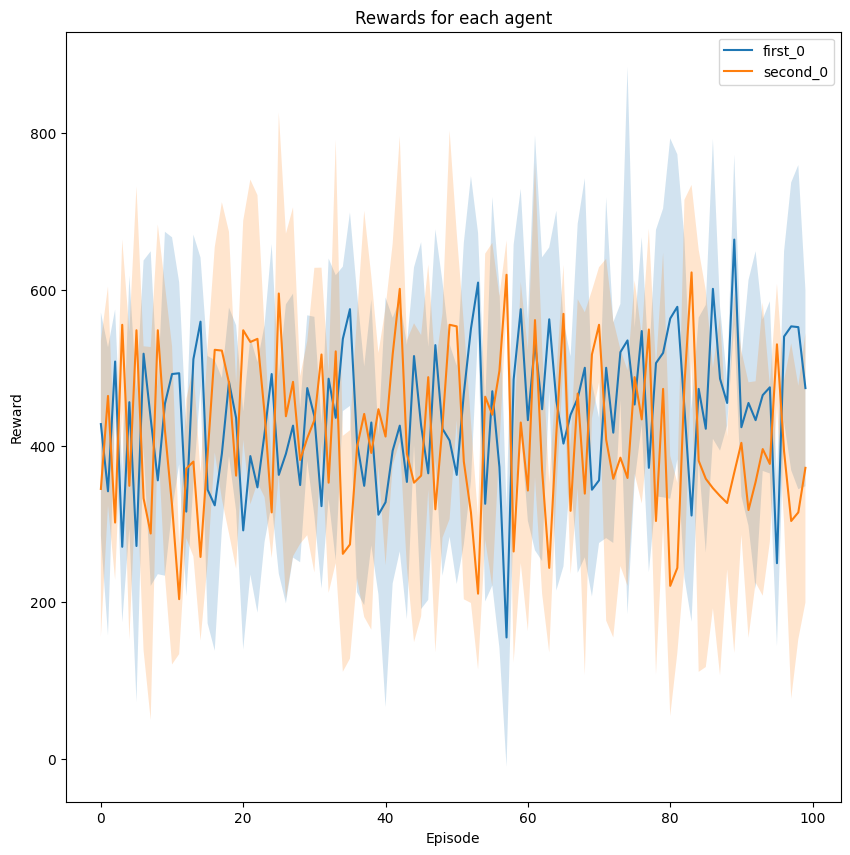

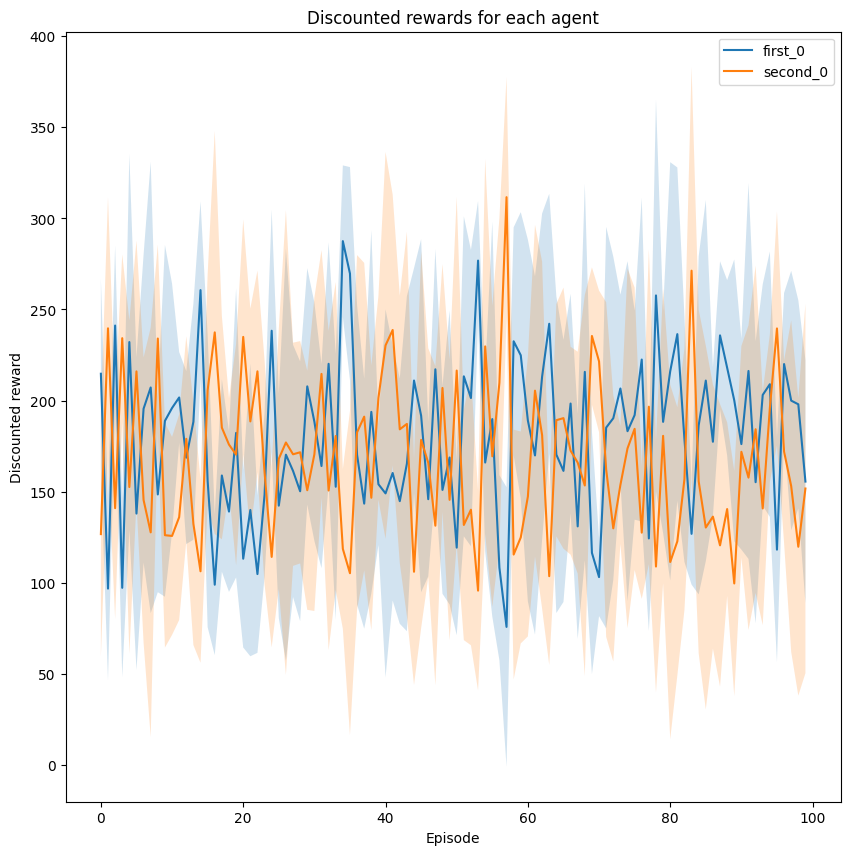

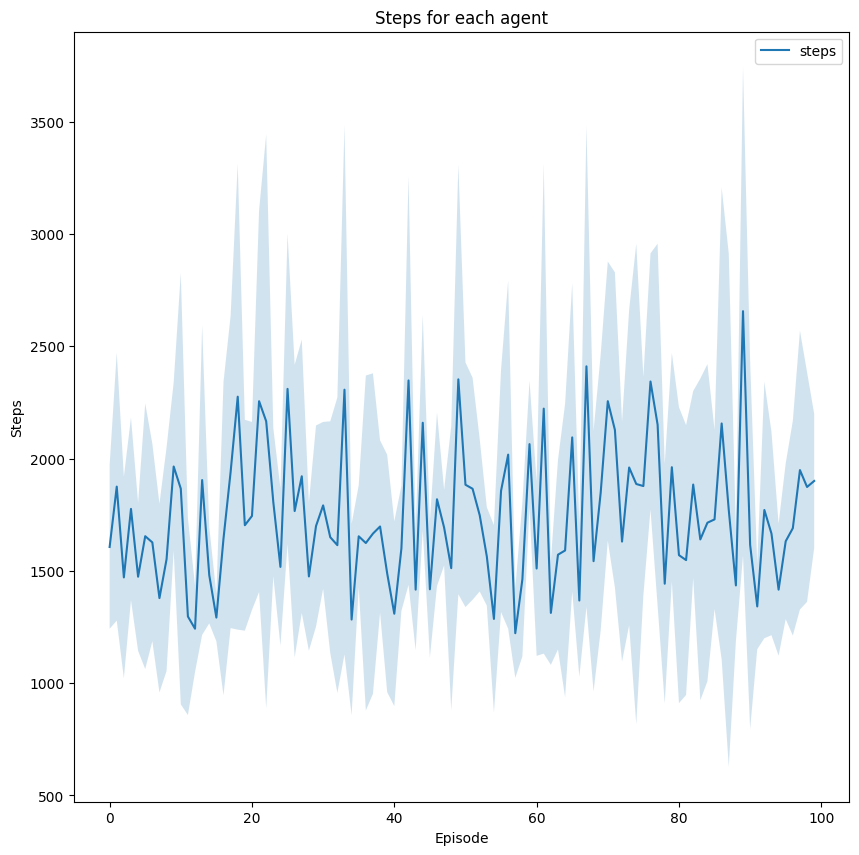

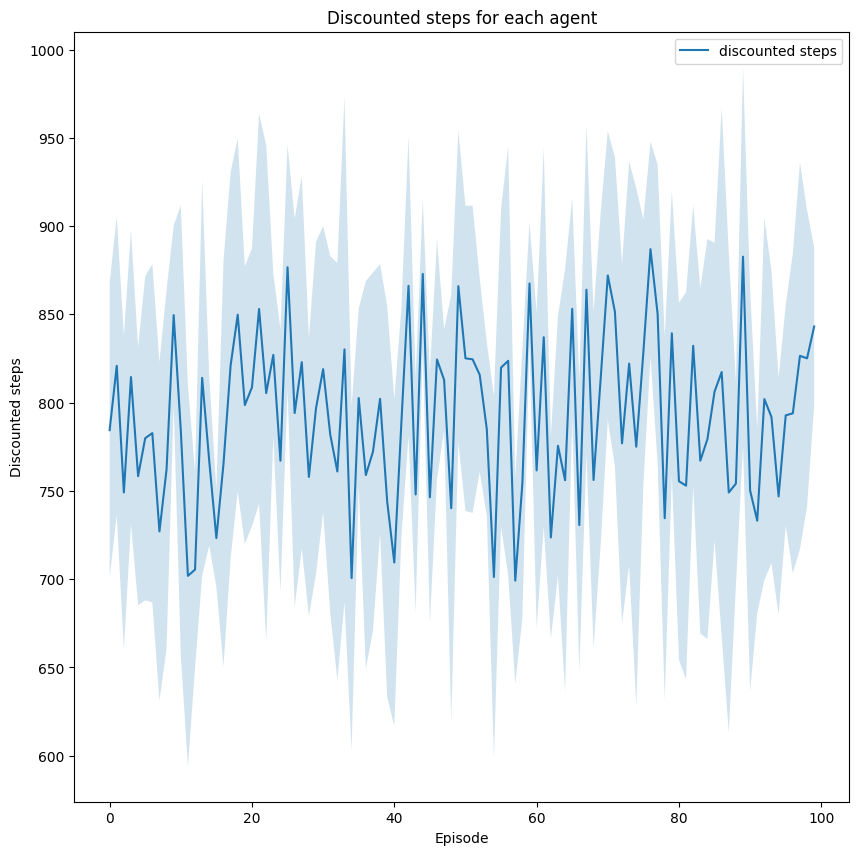

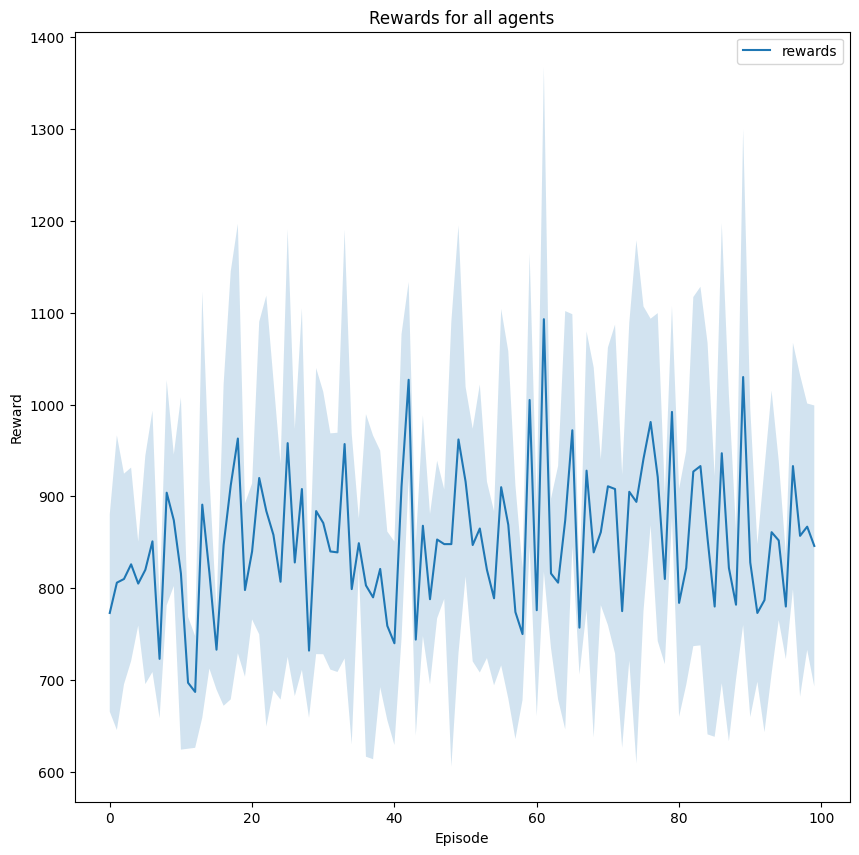

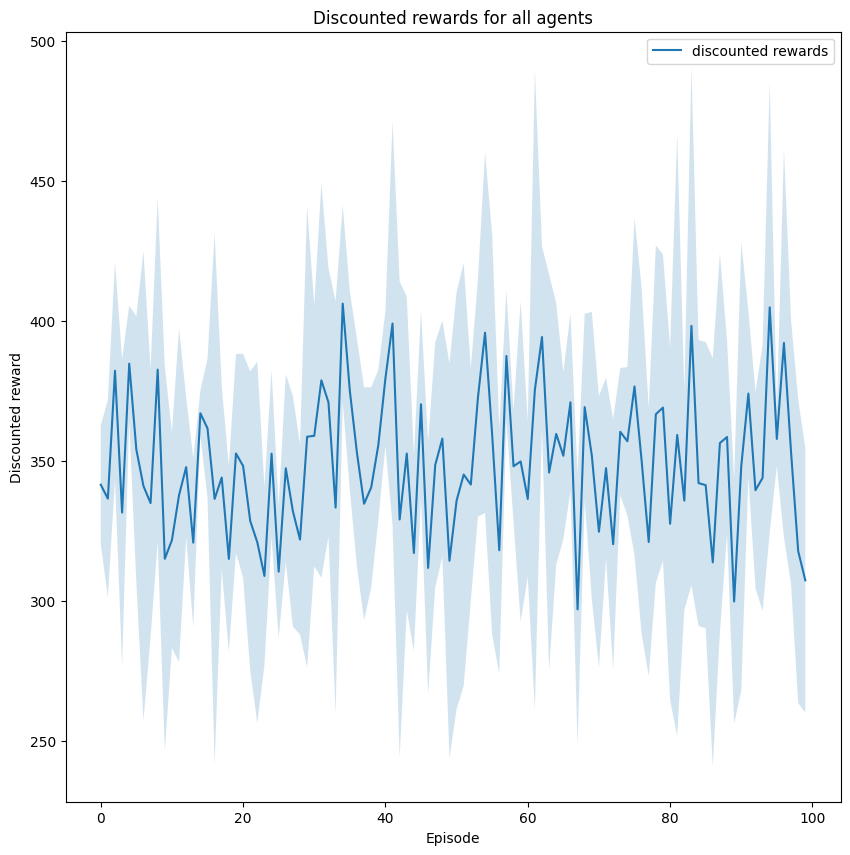

In [54]:
# Caluculate the mean and standard deviation of the rewards for each agent and all agents for each experiment
ep_rewards_uni_mean = {agent: np.mean(ep_rewards_uni[agent], axis=0) for agent in agent_names}
ep_rewards_uni_std = {agent: np.std(ep_rewards_uni[agent], axis=0) for agent in agent_names}
ep_rewards_d_uni_mean = {agent: np.mean(ep_rewards_d_uni[agent], axis=0) for agent in agent_names}
ep_rewards_d_uni_std = {agent: np.std(ep_rewards_d_uni[agent], axis=0) for agent in agent_names}
ep_steps_uni_mean = np.mean(ep_steps_uni, axis=0)
ep_steps_uni_std = np.std(ep_steps_uni, axis=0)
ep_steps_d_uni_mean = np.mean(ep_steps_d_uni, axis=0)
ep_steps_d_uni_std = np.std(ep_steps_d_uni, axis=0)
ep_rewards_all_uni_mean = np.mean(ep_rewards_all_uni, axis=0)
ep_rewards_all_uni_std = np.std(ep_rewards_all_uni, axis=0)
ep_rewards_d_all_uni_mean = np.mean(ep_rewards_d_all_uni, axis=0)
ep_rewards_d_all_uni_std = np.std(ep_rewards_d_all_uni, axis=0)

#plot the rewards (non-discounted) for each agent with mean and standard deviation of the rewards over all experiments all in one plot
plt.figure(figsize=(10, 10))
plt.title("Rewards for each agent")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(ep_rewards_uni_mean['first_0'], label="first_0")
plt.fill_between(np.arange(episode_count), ep_rewards_uni_mean['first_0'] - ep_rewards_uni_std['first_0'], ep_rewards_uni_mean['first_0'] + ep_rewards_uni_std['first_0'], alpha=0.2)
plt.plot(ep_rewards_uni_mean['second_0'], label="second_0")
plt.fill_between(np.arange(episode_count), ep_rewards_uni_mean['second_0'] - ep_rewards_uni_std['second_0'], ep_rewards_uni_mean['second_0'] + ep_rewards_uni_std['second_0'], alpha=0.2)
plt.legend()
plt.show()

#plot the discounted rewards for each agent with mean and standard deviation of the rewards over all experiments all in one plot
plt.figure(figsize=(10, 10))
plt.title("Discounted rewards for each agent")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
plt.plot(ep_rewards_d_uni_mean['first_0'], label="first_0")
plt.fill_between(np.arange(episode_count), ep_rewards_d_uni_mean['first_0'] - ep_rewards_d_uni_std['first_0'], ep_rewards_d_uni_mean['first_0'] + ep_rewards_d_uni_std['first_0'], alpha=0.2)
plt.plot(ep_rewards_d_uni_mean['second_0'], label="second_0")
plt.fill_between(np.arange(episode_count), ep_rewards_d_uni_mean['second_0'] - ep_rewards_d_uni_std['second_0'], ep_rewards_d_uni_mean['second_0'] + ep_rewards_d_uni_std['second_0'], alpha=0.2)
plt.legend()
plt.show()

#plot the steps for all agents with mean and standard deviation of the steps over all experiments all in one plot
plt.figure(figsize=(10, 10))
plt.title("Steps for each agent")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.plot(ep_steps_uni_mean, label="steps")
plt.fill_between(np.arange(episode_count), ep_steps_uni_mean - ep_steps_uni_std, ep_steps_uni_mean + ep_steps_uni_std, alpha=0.2)
plt.legend()
plt.show()

#plot the discounted steps for all agents with mean and standard deviation of the steps over all experiments all in one plot
plt.figure(figsize=(10, 10))
plt.title("Discounted steps for each agent")
plt.xlabel("Episode")
plt.ylabel("Discounted steps")
plt.plot(ep_steps_d_uni_mean, label="discounted steps")
plt.fill_between(np.arange(episode_count), ep_steps_d_uni_mean - ep_steps_d_uni_std, ep_steps_d_uni_mean + ep_steps_d_uni_std, alpha=0.2)
plt.legend()
plt.show()

#plot the rewards for all agents with mean and standard deviation of the rewards over all experiments all in one plot
plt.figure(figsize=(10, 10))
plt.title("Rewards for all agents")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(ep_rewards_all_uni_mean, label="rewards")
plt.fill_between(np.arange(episode_count), ep_rewards_all_uni_mean - ep_rewards_all_uni_std, ep_rewards_all_uni_mean + ep_rewards_all_uni_std, alpha=0.2)
plt.legend()
plt.show()

#plot the discounted rewards for all agents with mean and standard deviation of the rewards over all experiments all in one plot
plt.figure(figsize=(10, 10))
plt.title("Discounted rewards for all agents")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
plt.plot(ep_rewards_d_all_uni_mean, label="discounted rewards")
plt.fill_between(np.arange(episode_count), ep_rewards_d_all_uni_mean - ep_rewards_d_all_uni_std, ep_rewards_d_all_uni_mean + ep_rewards_d_all_uni_std, alpha=0.2)
plt.legend()
plt.show()

## PPO agent

In [12]:
#TODO

## MADDPG agent

In [ ]:
#TODO